In [2]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from scipy.spatial import KDTree

from joblib import Parallel, delayed

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy
import os

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

# import vortrace as vt
import Cvortrace
from vortrace.vortrace import ProjectionCloud

In [7]:
NPROC = 24

In [4]:
import importlib
importlib.reload(galaxy)

<module 'galaxy' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py'>

In [5]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
\usepackage{bm}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [6]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [8]:
# sim0 = ('142', '116', '04')
# sim1 = ('129', '116', '04')

sim0 = ('129', '142', '04') # aa
sim1 = ('129', '116', '04') # a
# sim1 = ('142', '129', '06') # e

In [9]:
def load_galaxy(sim, idx=320):
    if sim=='iso':
        path = 'runs/MW7iso/lvl4-Ngb64/output'
        return galaxy.Galaxy(basepath + path, idx, orient=True)
    else:
        Rs, Vv, ecc = sim
        key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
        return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [10]:
def gadget_spline(u, h=1, M=1):
    pre = M * 8 / (np.pi * h**3)
    ans = np.zeros_like(u)
    ans0 = 1 - 6*u**2 + 6 * u**3
    ans1 = 2 * (1-u)**3
    
    key0 = u <= 0.5
    key1 = np.logical_and(u > 0.5, u <= 1)
    ans[key0] = ans0[key0]
    ans[key1] = ans1[key1]
    
    ans *= pre
    
    return ans

def get_sigma_interp():
    blist = np.linspace(0, 1, 1024)
    slist = np.linspace(-1, 1, 1024)
    bgrid, sgrid = np.meshgrid(blist, slist, indexing='ij')
    
    rgrid = np.sqrt(bgrid**2 + sgrid**2)
    Wgrid = gadget_spline(rgrid, 1)
    
    sigma = np.trapz(Wgrid, slist, axis=1)
    return blist, sigma

# @njit
def sum_kernel_surface_dens(xpts, ypts, x, y, M, h, bint, sigmaint):
    
    pos = np.transpose([x, y])
    sigma = np.zeros(len(xpts)*len(ypts))
    
    xgrid, ygrid = np.meshgrid(xpts, ypts, indexing='ij')
    grid = np.transpose([xgrid.ravel(), ygrid.ravel()])
    
    tree_grid = KDTree(grid)

    # now do a ball query
    ball_idx = tree_grid.query_ball_point(pos, h)
    
    ball_idx_filter = [b for b in ball_idx if b]
    
    part_idx = np.concatenate([[i] * len(b) for i,b in enumerate(ball_idx) if b])
    ball_idx = np.concatenate(ball_idx_filter)
    
    # now get impact parameter
    b = np.linalg.norm(pos[part_idx] - grid[ball_idx], axis=1)
    sigma_ = M[part_idx]/h[part_idx]**3 * np.interp(b/h[part_idx], bint, sigmaint)
    sigma = np.bincount(ball_idx, weights=sigma_, minlength=len(xpts)*len(ypts))

    sigma = np.reshape(sigma, (len(xpts), len(ypts)))

    return sigma

In [11]:
def get_star_maps(gal, L, Nres):
    # get 
    sn, sub = gal.sn, gal.sub
    if sn.NumPart_Total[4] == 0:
        return np.zeros((Nres, Nres)), np.zeros((Nres, Nres))
    
    is_star = sn.part4.GFM_StellarFormationTime > 0
    if np.sum(is_star) == 0:
        return np.zeros((Nres, Nres)), np.zeros((Nres, Nres))
    
    pos = sn.part4.rotpos[is_star]
    mass = sn.part4.mass.value[is_star]

    dL = L/Nres
    xpts = np.arange(-L/2, L/2, dL) + dL/2.
    ypts = np.arange(-L/2, L/2, dL) + dL/2.
    zpts = np.arange(-L/2, L/2, dL) + dL/2.
    
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]

    # get softening lengths
    tree = KDTree(pos)
    h, _ = tree.query(pos, 33)
    h = h[:,-1]
    
    bint, sigmaint = get_sigma_interp()
    Hxy = sum_kernel_surface_dens(xpts, ypts, x, y, mass, h, bint, sigmaint)
    Hxz = sum_kernel_surface_dens(xpts, zpts, x, z, mass, h, bint, sigmaint)
    
    # Hxy, _, _, _ = binned_statistic_2d(x, y, mass/dx/dy, statistic='sum', bins=[xbins, ybins])
    # Hxz, _, _, _ = binned_statistic_2d(x, z, mass/dx/dz, statistic='sum', bins=[xbins, zbins])
    
    return Hxy, Hxz

def get_gas_maps(gal, L, Nres, logFeH0=None, dlogFeH=None, onlysf=False):
    # reshift box
    pos = np.copy(gal.sn.part0.rotpos)
    rho = np.copy(gal.sn.part0.rho.value)
    logfeh = np.log10(np.copy(gal.sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON))
    
    if logFeH0 is not None:
        mask = np.logical_and(logfeh > logFeH0 - dlogFeH/2., logfeh < logFeH0 + dlogFeH/2.)
        rho[np.logical_not(mask)] = 0.0
    
    if onlysf:
        mask = gal.sn.part0.sfr == 0
        rho[mask] = 0
    
    pos += 3*L
    boundbox = [0, 6*L, 0, 6*L, 0, 6*L]
    in_box = np.full(len(pos), True)
    for i in range(3):
        in_box_i = np.logical_and(pos[:,i] > boundbox[2*i], pos[:,i] < boundbox[2*i+1])
        in_box = np.logical_and(in_box, in_box_i)
    
    pos = pos[in_box]
    rho = rho[in_box]
    
    pc = ProjectionCloud(pos, rho, boundbox=boundbox)
    pc._cloud.buildTree()
    
    dx = L/Nres
    
    grid_points = np.linspace(-L/2+dx/2., L/2-dx/2., Nres)
    edge_points = np.array([-L/2., L/2.])
    
    # x-y projection
    xv, yv, zv = np.meshgrid(grid_points, grid_points, edge_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.array([xv, yv, zv], order='F')
    pts = np.transpose(pts)
    pts_start = pts[::2] + 3*L
    pts_end = pts[1::2] + 3*L
    
    proj = Cvortrace.Projection(pts_start, pts_end)
    proj.makeProjection(pc._cloud)
    sigma_xy = proj.returnProjection()
    # sigma_xy /= dx**2
    # print(sigma_xy[:10])
    sigma_xy = np.reshape(sigma_xy, (Nres, Nres)).T # transpose for some reason?
    
    # x-z projection
    xv, yv, zv = np.meshgrid(grid_points, edge_points, grid_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.array([xv, yv, zv], order='F')
    pts = np.transpose(pts)
    pts_start = pts[:Nres**2] + 3*L
    pts_end = pts[Nres**2:] + 3*L
    
    proj = Cvortrace.Projection(pts_start, pts_end)
    proj.makeProjection(pc._cloud)
    sigma_xz = proj.returnProjection()
    # sigma_xz /= dx**2
    sigma_xz = np.reshape(sigma_xz, (Nres, Nres))
    
    return sigma_xy, sigma_xz

def get_maps(sim, idx, k, theta,
             L=30, Nres=256, logFeH0=None, dlogFeH=None):
    
    gal = load_galaxy(sim, idx)
    
    # orient wrt input k, theta
    COM, COMV, _, _ = gal._get_COM_COMV()
    gal._orient(COM, COMV, k, theta)
    
    # get star surface density
    Hxy_s, Hxz_s = get_star_maps(gal, L, Nres)
    
    # get gas surface density
    Hxy_g, Hxz_g = get_gas_maps(gal, L, Nres)
    
    # Hxy_s, Hxz_s, Hxy_g, Hxz_g = None, None, None, None
    
    if logFeH0 is not None:
        Hxy_gFe, Hxz_gFe = get_gas_maps(gal, L, Nres, logFeH0=logFeH0, dlogFeH=dlogFeH)
        
        Hxy_gFe_sf, Hxz_gFe_sf = get_gas_maps(gal, L, Nres, logFeH0=logFeH0, dlogFeH=dlogFeH, onlysf=True)
    else:
        Hxy_gFe, Hxz_gFe = None, None
        Hxy_gFe_sf, Hxz_gFe_sf = None, None
                                             
    
    del gal
    return Hxy_s, Hxz_s, Hxy_g, Hxz_g, Hxy_gFe, Hxz_gFe, Hxy_gFe_sf, Hxz_gFe_sf

In [12]:
sim0

('129', '142', '04')

In [13]:
gal = load_galaxy(sim0, 320)
k, theta = gal.CenterOfMass.k, gal.CenterOfMass.theta

In [14]:
L = 100
_, _, _, _, Hxy, Hxz = get_maps(sim0, 100, k, theta, logFeH0=0., dlogFeH=0.1, L=L)

ValueError: too many values to unpack (expected 6)

In [ ]:
plt.hist(Hxy.ravel()[Hxy.ravel() > 0]*1e6)

In [ ]:
fig, ax = plt.subplots(1, 1)
data = Hxy.ravel()
# vmin = np.percentile(data[data > 0], 1)
# vmax = np.percentile(data[data > 0], 99)

vmin = 1e-7
vmax = 5e-5

Hxy[Hxy < vmin] = vmin
print(vmin, vmax)
im = ax.imshow(Hxy.T, origin='lower', norm=mpl.colors.LogNorm(vmin, vmax), extent=[-L/2., L/2., -L/2., L/2.])
print(im.get_clim())

In [63]:
gal = load_galaxy(sim0, 160)
sn = gal.sn
logFeH0 = 0
dlogFeH = 0.001

logFeH = np.log10(sn.part0.GFM_Metals[:,8]/GFM_SOLAR_ABUNDANCE_IRON)
mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)

pos = sn.part0.pos[mask]
print(len(pos))

94


In [9]:
import importlib
importlib.reload(galaxy)

<module 'galaxy' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py'>

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py as h5
from tqdm import tqdm
import sys

from matplotlib.animation import FuncAnimation

time_conv = 977.793 # converts time units to Myr

class animate_maker(object):
    def __init__(self, fig, H00, H01, H10, H11, time, im00, im01, im10, im11, 
                 txt, txt_gas, txt_stars, vmin, vmax, vmin_star, vmax_star, 
                 name):
        self.fig = fig
        self.H00 = H00
        self.H01 = H01
        self.H10 = H10
        self.H11 = H11
        self.time = time
        
        self.im00 = im00
        self.im01 = im01
        self.im10 = im10
        self.im11 = im11
        self.txt = txt
        self.txt_gas = txt_gas
        self.txt_stars = txt_stars

        self.vmin = vmin
        self.vmax = vmax
        self.vmin_star = vmin_star
        self.vmax_star = vmax_star
        self.name = name
    
        self.alpha_list = self.get_alpha_list(H00.shape[0])
    
    def get_alpha_list(self, nframe):
        alpha_list = np.zeros(nframe)
        
        # choose what frame the fade starts and what frame it ends
        st = 15
        end = 32
        
        m = -1 / (end - st)
        b = -m * end
        
        alpha_list = m * np.arange(nframe) + b
        alpha_list = np.clip(alpha_list, 0, 1)
        
        return alpha_list

    def __call__(self, frame):
        H00_ = np.clip(np.copy(self.H00[frame]), self.vmin, self.vmax)
        H01_ = np.clip(np.copy(self.H01[frame]), self.vmin_star, self.vmax_star)
        H10_ = np.clip(np.copy(self.H10[frame]), self.vmin, self.vmax)
        H11_ = np.clip(np.copy(self.H11[frame]), self.vmin_star, self.vmax_star)
        
        self.im00.set_data(H00_.T)
        self.im01.set_data(H01_.T)
        self.im10.set_data(H10_.T)
        self.im11.set_data(H11_.T)
        
        self.txt.set_text(r'$'+'{0:.2f}'.format(self.time[frame])+r'\,\textrm{Gyr}$')
        
        self.txt_gas.set_alpha(self.alpha_list[frame])
        self.txt_stars.set_alpha(self.alpha_list[frame])
        
        if frame in [0, 60, 70, 80, 90, 100, 110, 120, 200, 320]:
            self.fig.savefig(self.name+'/'+self.name+'_frame'+str(frame)+'.pdf')
        
        return (self.im00, self.im01, self.im10, self.im11, self.txt, self.txt_gas, self.txt_stars)

def make_movie(H00, H01, H10, H11, time, nres, vmin, vmax, name,
               vmin_star=None, vmax_star=None, fps=16,
               scale_bar=None):
                             
    if not os.path.exists(name):
        os.makedirs(name)
    
    # initialize fig and ax, remove boundary
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    for x in axs.ravel():
        x.axis("off")
        x.set_aspect('equal')
    
    if vmin_star is None:
        vmin_star = vmin
    if vmax_star is None:
        vmax_star = vmax

    im00 = axs[0][0].imshow(np.full((nres, nres), vmin), origin='lower', 
                            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                            extent=[0, 1, 0, 1], cmap='Blues')
    im01 = axs[0][1].imshow(np.full((nres, nres), vmin_star), origin='lower', 
                            norm=mpl.colors.LogNorm(vmin=vmin_star, vmax=vmax_star),
                           extent=[0, 1, 0, 1], cmap='Oranges')
    im10 = axs[1][0].imshow(np.full((nres, nres), vmin), origin='lower', 
                            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                           extent=[0, 1, 0, 1], cmap='Blues')
    im11 = axs[1][1].imshow(np.full((nres, nres), vmin_star), origin='lower', 
                            norm=mpl.colors.LogNorm(vmin=vmin_star, vmax=vmax_star),
                           extent=[0, 1, 0, 1], cmap='Oranges')

    # initialize time if needed
    txt = axs[0][1].text(0.6, 0.85, ' ', transform=axs[0][1].transAxes, fontsize=12, c='k')

    # add scale line
    if scale_bar is not None:
        axs[1][0].plot([0.15, 0.25], [0.1, 0.1], c='k', lw=2)
        axs[1][0].text(0.2, 0.15, r'$'+scale_bar+r'\,\textrm{kpc}$', ha='center', c='k', 
                       weight='bold', fontsize=12)
    
    # add gas and stars text, which will fade out
    txt_gas   = axs[0][0].text(0.15, 0.9, r'$\textrm{gas}$', c='k', fontsize=12)
    txt_stars = axs[0][1].text(0.15, 0.9, r'$\textrm{stars}$', c='k', fontsize=12)  
    
    # fig.tight_layout()
    
    animate = animate_maker(fig, H00, H01, H10, H11, time, im00, im01, im10, im11, txt, txt_gas, txt_stars,
                            vmin, vmax, vmin_star, vmax_star, name)


    # initialize animator
    animation = FuncAnimation(fig, animate, tqdm(range(len(H00)), position=0, leave=True), 
                              interval=1000 / fps)
    animation.save(name+'/'+name+'.mp4', dpi=nres*2)
    
    plt.close()

In [22]:
gal = load_galaxy(sim0, 320)
k, theta = gal.CenterOfMass.k, gal.CenterOfMass.theta

In [23]:
def do_movie(sim, name, logFeH0=None, dlogFeH=None):
    gal = load_galaxy(sim, 320)
    k, theta = gal.CenterOfMass.k, gal.CenterOfMass.theta
    
    # get L=30
    L = 30
    out = Parallel(n_jobs=NPROC)(delayed(get_maps)(sim, i, k, theta, Nres=256, L=L) 
                          for i in tqdm(range(320+1), position=0, leave=True))

    Hxy_s_30 = np.array([out[i][0] for i in range(len(out))])
    Hxz_s_30 = np.array([out[i][1] for i in range(len(out))])
    Hxy_g_30 = np.array([out[i][2] for i in range(len(out))])
    Hxz_g_30 = np.array([out[i][3] for i in range(len(out))])
    
    # get L=100
    L = 100
    out = Parallel(n_jobs=NPROC)(delayed(get_maps)(sim, i, k, theta, Nres=256, L=L, logFeH0=logFeH0, dlogFeH=dlogFeH) 
                          for i in tqdm(range(320+1), position=0, leave=True))

    Hxy_s_100 = np.array([out[i][0] for i in range(len(out))])
    Hxz_s_100 = np.array([out[i][1] for i in range(len(out))])
    Hxy_g_100 = np.array([out[i][2] for i in range(len(out))])
    Hxz_g_100 = np.array([out[i][3] for i in range(len(out))])
    
    time = 0.025*np.arange(320+1)
    
    make_movie(Hxz_g_30, Hxz_s_30, Hxy_g_30, Hxy_s_30, time, Hxy_g_30[0].shape[0], 
           1e-4, 1e-2, name+'_L30',
           vmin_star=1e-4, vmax_star = 1, scale_bar='3')
    
    make_movie(Hxz_g_100, Hxz_s_100, Hxy_g_100, Hxy_s_100, time, Hxy_g_100[0].shape[0], 
           1e-4, 1e-2, name+'_L100',
           vmin_star=1e-4, vmax_star = 1, scale_bar='10')
    
    make_movie(Hxz_g_100, Hxz_s_100, Hxy_g_100, Hxy_s_100, time, Hxy_g_100[0].shape[0], 
           1e-6, 1e-2, name+'_L100_lowdens',
           vmin_star=1e-4, vmax_star=1, scale_bar='10')
    
    
    if logFeH0 is not None:
        assert dlogFeH is not None
        
        Hxy_gFe_100 = np.array([out[i][4] for i in range(len(out))])
        Hxz_gFe_100 = np.array([out[i][5] for i in range(len(out))])
        
        Hxy_gFe_sf_100 = np.array([out[i][6] for i in range(len(out))])
        Hxz_gFe_sf_100 = np.array([out[i][7] for i in range(len(out))])
        
        
        vmin = 1e-7
        vmax = 5e-5
        
        make_movie(Hxz_gFe_100, Hxz_s_100, Hxy_gFe_100, Hxy_s_100, time, Hxy_g_100[0].shape[0], 
           vmin, vmax, name+'_L100_Fe',
           vmin_star=1e-4, vmax_star=1, scale_bar='10')
        
        make_movie(Hxz_gFe_sf_100, Hxz_s_100, Hxy_gFe_sf_100, Hxy_s_100, time, Hxy_g_100[0].shape[0], 
           vmin, vmax, name+'_L100_Fe_sf',
           vmin_star=1e-4, vmax_star=1, scale_bar='10')
    
    # make_movie(Hxz_g_100, Hxz_s_100, Hxy_g_100, Hxy_s_100, time, Hxy_g_100[0].shape[0], 
           # 1e-6, 1e-4, name+'_L100_lowdens2',
           # vmin_star=1e-4, vmax_star=1, scale_bar='10')

In [16]:
# do_movie(iso, 'iso')

In [24]:
do_movie(sim0, 'bimodal')

100%|█████████▉| 320/321 [01:50<00:00,  2.91it/s]

 60%|█████▉    | 192/321 [00:32<00:23,  5.43it/s]/n/home01/abeane/venv/note/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|█████████▉| 320/321 [02:25<00:00,  2.23it/s]

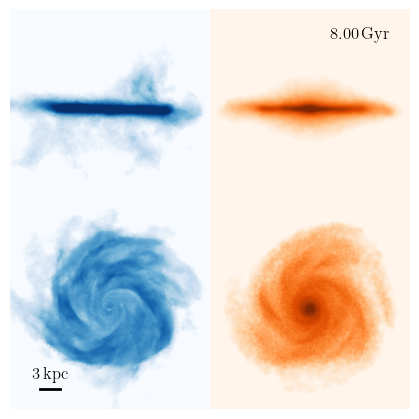

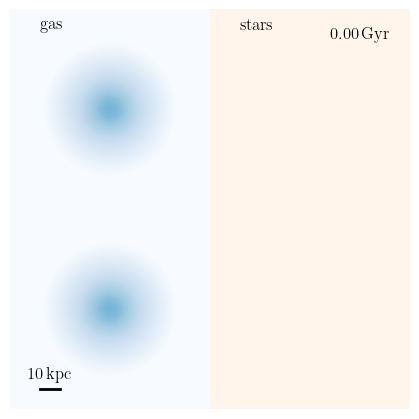

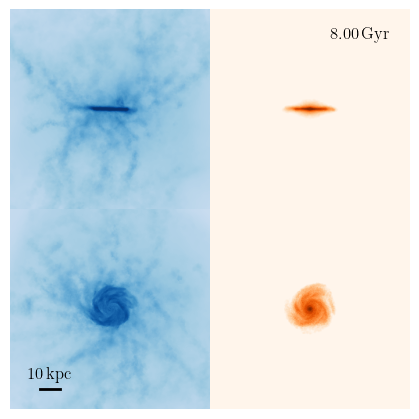

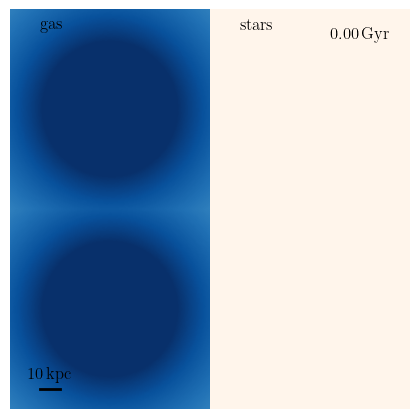

In [23]:
do_movie(sim1, 'unimodal')

In [88]:
print(0)

0


In [87]:
sim = ('116', '142', '05')
do_movie(sim, 'bi2', logFeH0=0.0, dlogFeH=0.1)

sim = ('129', '116', '05')
do_movie(sim, 'uni2', logFeH0=0.0, dlogFeH=0.1)

 60%|█████▉    | 192/321 [01:23<01:03,  2.03it/s]/n/home01/abeane/venv/note/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 60%|█████▉    | 192/321 [01:24<01:04,  2.01it/s]/n/home01/abeane/venv/note/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|█████████▉| 320/321 [02:26<00:00,  2.20it/s]

### 